<a href="https://colab.research.google.com/github/Ashrafalaghbari/oil-production-forecasting/blob/main/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%autosave 60

Autosaving every 60 seconds


In [1]:
import os
import numpy as np
import random 
from numpy.random import randint, rand
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import itertools
import re
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Activation, Input, Flatten
from keras.layers import LSTM, Conv1D
from keras.models import Model
import keras.backend as k
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt, inf

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# # check if GPU is utilized 
# device_name = tf.config.experimental.list_physical_devices()[-1][-1]
# if device_name != 'GPU':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(tf.test.gpu_device_name()))

In [3]:
# Select the best features
def select_features(df, target, correlation_type, threshold):
    if (threshold < -1 ) | (threshold > 1 ) :
            raise SystemError('correlation threshold is out of bounds')
    features = df.corr(correlation_type).loc[target].drop(target)
    best_features = features.where(abs(features) > threshold).dropna()
    df = pd.concat([df[target], df[best_features.index]], axis=1)
    return df

# convert series to supervised learning using a sliding  window approach
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# scale train and test data to new feature range[0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

#Evaluation metrics
# compute RMSPE
def RMSPE(x,y):
	result=0
	for i in range(len(x)):
		result += ((x[i]-y[i])/x[i])**2
	result /= len(x)
	result = sqrt(result)
	result *= 100
	return result

# compute MAPE
def MAPE(x,y):
	result=0
	for i in range(len(x)):
		result += abs((x[i]-y[i])/x[i])
	result /= len(x)
	result *= 100
	return result

# compute wMAPE weighted absolute percentage error
def wMAPE(actual, predicted): 
    result_nom = 0
    result_deno = 0
    for i in range(len(actual)):
        result_nom +=  abs(actual[i] - predicted[i])
        result_deno +=  abs(actual[i]) 
    result = result_nom/result_deno
    return result *100

def SMAPE(actual, predicted): #Symmetric (adjusted) MEAN ABSOLUTE PERCENTAGE ERROR (SMAPE)
    result = 0
    for i in range(len(actual)):
        result += abs(actual[i] - predicted[i])/(abs(actual[i]) + abs(predicted[i]))
    result = 2 * result/ len(actual) 
    return result * 100

In [4]:
#load dataset
series = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv', 
                     parse_dates=["DATEPRD"], index_col="DATEPRD")
days = pd.Series(range(len(series),0, -1 ), index=series.index)
series.insert(0, 'days', days)
series['days(t)'] = series['days'].shift(-1)
series["AVG_CHOKE_SIZE_P(t)"] = series['AVG_CHOKE_SIZE_P'].shift(-1)
series["ON_STREAM_HRS(t)"] = series['ON_STREAM_HRS'].shift(-1)
series['interaction_effect_onNext_oilRate'] = series["AVG_CHOKE_SIZE_P(t)"]  * series["ON_STREAM_HRS(t)"] * series['days(t)']
series.dropna(inplace=True)
# # select feature based on correlation
# # series = select_features(series, "BORE_OIL_VOL", "spearman", 0.2)
# # select features manually
series =series[[
                'interaction_effect_onNext_oilRate',
                "BORE_GAS_VOL", 
                "BORE_OIL_VOL"
                ]] 
series.shape    

(1907, 3)

In [ ]:
#grid search 
def get_hyper_param(n_epochs, num_hidden_layers, num_neurons, batch_size, window_size):
    """ 
    This is a grid search function that generates all possible comibinations
    from the search space 

    Args:
    n_epochs: number of epochs
    num_hidden_layers: number of hidden layers
    num_neurons: number of neurons same for both input and hidden layers 
    batch_size: number of batch size 
    window_size: historical timesteps in the sliding window
    
    """
    hyper_param = []
    for current_params in itertools.product(n_epochs, num_hidden_layers, num_neurons, batch_size, window_size):
        hyper_param.append(list(current_params))
    return hyper_param

# Seacrh space
n_epochs = [500]
num_hidden_layers = [1, 2]
num_neurons = [20, 40, 80, 160]
batch_size = [2, 4]
window_size = [2, 4, 8]

hyper_param = get_hyper_param(n_epochs, num_hidden_layers, num_neurons, batch_size, window_size)
len(hyper_param)# print the number of combinations
hyper_param = hyper_param[-8:]

In [ ]:
# # run the model and repeat the evaluation to reduce the certainty asscoicated with the random initialization of model weights
# def run_model(n_repeats = 1):
#     scores = [fit_lstm() for _ in range(n_repeats)]
#     result = pd.DataFrame(scores)
#     result = result.groupby("best_params").mean()
#     return result

In [ ]:
steps_ahead = 1  
    # Create a new directory in My Drive
directory = '/content/drive/My Drive/my_trained_models'
if not os.path.exists(directory):
    os.makedirs(directory)

min_val_loss = math.inf 
for n_epochs, num_hidden_layers, num_neurons, batch_size, window_size in hyper_param:
    print('n_epochs', n_epochs, 'num_hidden_layers', num_hidden_layers, 'num_neurons',
            num_neurons, "batch_size", batch_size, 'window_size', window_size)
    
    # setting the session configurations for reproducibility.
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    np.random.seed(12345)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)
    from keras import backend as K
    tf.random.set_seed(1234)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
    K.set_session(sess)

    #feature engineering
    # # convert the stationary series to supervise learning
    series_supervised = series_to_supervised(series, series.columns, n_in= window_size, n_out= steps_ahead, dropnan=True)   

    # drop columns we don't want to predict
    pattern = re.compile(r"(t-)|^BORE_OIL_VOL.*")
    # Extract the column names that match the pattern
    matching_columns = [col for col in series_supervised.columns if re.search(pattern, col)]
    series_supervised = series_supervised[matching_columns]

    # # split into train and test sets
    series_supervised = series_supervised.values
    train_size = int(series_supervised.shape[0] * 0.8)
    test_size = series_supervised.shape[0] - train_size
    train, test = series_supervised[0:train_size], series_supervised[train_size:]
    # print("train.shape:",train.shape, "test.shape:",test.shape)

    # scale  the data to a feature range(0,1)
    scaler, train_scaled, test_scaled = scale(train, test)
    # print('train_scaled.shape:',train_scaled.shape, "test_scaled.shape:",test_scaled.shape)

    # reshape input to be 3D [samples, window_size, features]
    n_features = len(series.columns)
    train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
    train_X = train_X.reshape(train_X.shape[0], window_size, n_features)
    test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
    test_X = test_X.reshape(test_X.shape[0], window_size, n_features )
    # print("train_X.shape:",train_X.shape, "train_y.shape:",train_y.shape,
    #         "test_X.shape:", test_X.shape,"test_y.shape:",test_y.shape)

    # build the LSTM model
    model =  Sequential()

    if num_hidden_layers == 1:
        model.add(LSTM(num_neurons, activation='tanh', input_shape = (window_size, n_features)))
        
    else:
        for num in range(num_hidden_layers-1):
            model.add(LSTM(num_neurons,activation='tanh', input_shape =(window_size, n_features), return_sequences=True))        
        model.add(LSTM(num_neurons))


    model.add(Dense(steps_ahead))
    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
    #prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0,
                                restore_best_weights=True, mode='min')

    model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, callbacks = [early_stopping],
                validation_data=(test_X, test_y), verbose=0, shuffle=False)
    
    current_val_loss = model.evaluate(test_X, test_y, verbose=2) #lstm_model.history['val_loss'][-1]
    if current_val_loss < min_val_loss:
        min_val_loss = current_val_loss
        best_params = [n_epochs,  num_hidden_layers, num_neurons, batch_size, window_size]
    
print('final best params',"n_epochs:",best_params[0],"num_hidden_layers:",
        best_params[1], "num_neurons:", best_params[2], "batch_size:", best_params[3],
        "window_size:",best_params[4]) 
print("best_params", str(best_params) , "MSE:",str(min_val_loss))#, lstm_model  

n_epochs 500 num_hidden_layers 1 num_neurons 20 batch_size 2 window_size 2
12/12 - 0s - loss: 2.0298e-04 - 38ms/epoch - 3ms/step
n_epochs 500 num_hidden_layers 1 num_neurons 20 batch_size 2 window_size 4
12/12 - 0s - loss: 1.4564e-04 - 36ms/epoch - 3ms/step
n_epochs 500 num_hidden_layers 1 num_neurons 20 batch_size 2 window_size 8
12/12 - 1s - loss: 1.2278e-04 - 511ms/epoch - 43ms/step
n_epochs 500 num_hidden_layers 1 num_neurons 20 batch_size 4 window_size 2
12/12 - 0s - loss: 2.0535e-04 - 35ms/epoch - 3ms/step
n_epochs 500 num_hidden_layers 1 num_neurons 20 batch_size 4 window_size 4
12/12 - 0s - loss: 1.3400e-04 - 37ms/epoch - 3ms/step
n_epochs 500 num_hidden_layers 1 num_neurons 20 batch_size 4 window_size 8
12/12 - 1s - loss: 1.1998e-04 - 520ms/epoch - 43ms/step
n_epochs 500 num_hidden_layers 1 num_neurons 40 batch_size 2 window_size 2
12/12 - 0s - loss: 1.8722e-04 - 42ms/epoch - 3ms/step
n_epochs 500 num_hidden_layers 1 num_neurons 40 batch_size 2 window_size 4
12/12 - 0s - loss:

In [ ]:
#n_epochs 500 num_hidden_layers 1 num_neurons 40 batch_size 4 window_size 8
#12/12 - 1s - loss: 1.1690e-04 - 502ms/epoch - 42ms/step

In [ ]:
steps_ahead = 1  
    # Create a new directory in My Drive
directory = '/content/drive/My Drive/my_trained_models'
if not os.path.exists(directory):
    os.makedirs(directory)

min_val_loss = math.inf 
for n_epochs, num_hidden_layers, num_neurons, batch_size, window_size in hyper_param:
    print('n_epochs', n_epochs, 'num_hidden_layers', num_hidden_layers, 'num_neurons',
            num_neurons, "batch_size", batch_size, 'window_size', window_size)
    
    # setting the session configurations for reproducibility.
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    np.random.seed(12345)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)
    from keras import backend as K
    tf.random.set_seed(1234)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
    K.set_session(sess)

    #feature engineering
    # # convert the stationary series to supervise learning
    series_supervised = series_to_supervised(series, series.columns, n_in= window_size, n_out= steps_ahead, dropnan=True)   

    # drop columns we don't want to predict
    pattern = re.compile(r"(t-)|^BORE_OIL_VOL.*")
    # Extract the column names that match the pattern
    matching_columns = [col for col in series_supervised.columns if re.search(pattern, col)]
    series_supervised = series_supervised[matching_columns]

    # # split into train and test sets
    series_supervised = series_supervised.values
    train_size = int(series_supervised.shape[0] * 0.8)
    test_size = series_supervised.shape[0] - train_size
    train, test = series_supervised[0:train_size], series_supervised[train_size:]
    # print("train.shape:",train.shape, "test.shape:",test.shape)

    # scale  the data to a feature range(0,1)
    scaler, train_scaled, test_scaled = scale(train, test)
    # print('train_scaled.shape:',train_scaled.shape, "test_scaled.shape:",test_scaled.shape)

    # reshape input to be 3D [samples, window_size, features]
    n_features = len(series.columns)
    train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
    train_X = train_X.reshape(train_X.shape[0], window_size, n_features)
    test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
    test_X = test_X.reshape(test_X.shape[0], window_size, n_features )
    # print("train_X.shape:",train_X.shape, "train_y.shape:",train_y.shape,
    #         "test_X.shape:", test_X.shape,"test_y.shape:",test_y.shape)

    # build the LSTM model
    model =  Sequential()

    if num_hidden_layers == 1:
        model.add(LSTM(num_neurons, activation='tanh', input_shape = (window_size, n_features)))
        
    else:
        for num in range(num_hidden_layers-1):
            model.add(LSTM(num_neurons,activation='tanh', input_shape =(window_size, n_features), return_sequences=True))        
        model.add(LSTM(num_neurons))


    model.add(Dense(steps_ahead))
    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
    #prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0,
                                restore_best_weights=True, mode='min')

    model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, callbacks = [early_stopping],
                validation_data=(test_X, test_y), verbose=0, shuffle=False)
    
    current_val_loss = model.evaluate(test_X, test_y, verbose=2) #lstm_model.history['val_loss'][-1]
    if current_val_loss < min_val_loss:
        min_val_loss = current_val_loss
        best_params = [n_epochs,  num_hidden_layers, num_neurons, batch_size, window_size]
    
print('final best params',"n_epochs:",best_params[0],"num_hidden_layers:",
        best_params[1], "num_neurons:", best_params[2], "batch_size:", best_params[3],
        "window_size:",best_params[4]) 
print("best_params", str(best_params) , "MSE:",str(min_val_loss))#, lstm_model  

n_epochs 500 num_hidden_layers 2 num_neurons 80 batch_size 4 window_size 4
12/12 - 0s - loss: 1.4165e-04 - 46ms/epoch - 4ms/step
n_epochs 500 num_hidden_layers 2 num_neurons 80 batch_size 4 window_size 8
12/12 - 1s - loss: 1.2938e-04 - 839ms/epoch - 70ms/step
n_epochs 500 num_hidden_layers 2 num_neurons 160 batch_size 2 window_size 2
12/12 - 0s - loss: 2.2464e-04 - 46ms/epoch - 4ms/step
n_epochs 500 num_hidden_layers 2 num_neurons 160 batch_size 2 window_size 4
12/12 - 0s - loss: 1.5589e-04 - 67ms/epoch - 6ms/step
n_epochs 500 num_hidden_layers 2 num_neurons 160 batch_size 2 window_size 8
12/12 - 1s - loss: 1.3365e-04 - 1s/epoch - 105ms/step
n_epochs 500 num_hidden_layers 2 num_neurons 160 batch_size 4 window_size 2
12/12 - 0s - loss: 1.8128e-04 - 47ms/epoch - 4ms/step
n_epochs 500 num_hidden_layers 2 num_neurons 160 batch_size 4 window_size 4
12/12 - 0s - loss: 1.3683e-04 - 64ms/epoch - 5ms/step
n_epochs 500 num_hidden_layers 2 num_neurons 160 batch_size 4 window_size 8
12/12 - 1s - l

In [5]:
steps_ahead = 1
# Define window size and number of the steps ahead for forecasting
n_epochs = 500
num_hidden_layers = 1
num_neurons = 40
batch_size = 4
window_size = 8

# # convert the stationary series to supervise learning using sliding window approach
series_supervised = series_to_supervised(series, series.columns, n_in= window_size, n_out= steps_ahead, dropnan=True)   

# drop columns we don't want to predict
pattern = re.compile(r"(t-)|^BORE_OIL_VOL.*")

# Extract the column names that match the pattern
matching_columns = [col for col in series_supervised.columns if re.search(pattern, col)]
series_supervised = series_supervised[matching_columns]



# # split into train and test sets
n_features = int((len(series_supervised.columns) -steps_ahead)/window_size)
series_supervised = series_supervised.values
train_size = int(series_supervised.shape[0] * 0.8)
test_size = series_supervised.shape[0] - train_size
train, test = series_supervised[0:train_size], series_supervised[train_size:]
print("train.shape:",train.shape, "test.shape:",test.shape)

# scale  the data to a feature range(0,1)
scaler, train_scaled, test_scaled = scale(train, test)
print('train_scaled.shape:',train_scaled.shape, "test_scaled.shape:",test_scaled.shape)

# # reshape input to be 3D [samples, window_size, features]
train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
train_X = train_X.reshape(train_X.shape[0], window_size, n_features)
test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
test_X = test_X.reshape(test_X.shape[0], window_size, n_features )
print("train_X.shape:",train_X.shape, "train_y.shape:",train_y.shape,
        "test_X.shape:", test_X.shape,"test_y.shape:",test_y.shape)


# setting the session configurations for reproducibility.
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)
from keras import backend as K
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
K.set_session(sess)

model =  Sequential()

if num_hidden_layers == 1:
    model.add(LSTM(num_neurons, activation='tanh', input_shape = (window_size, n_features)))
    
else:
    for num in range(num_hidden_layers-1):
        model.add(LSTM(num_neurons,activation='tanh', input_shape =(window_size, n_features), return_sequences=True))        
    model.add(LSTM(num_neurons))
        
model.add(Dense(steps_ahead))
model.compile(loss='mean_squared_error',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
#prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0,
                            restore_best_weights=True, mode='min')

history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, callbacks = [early_stopping],
            validation_data=(test_X, test_y), verbose=2, shuffle=False)
model.evaluate(test_X, test_y)

train.shape: (1519, 25) test.shape: (380, 25)
train_scaled.shape: (1519, 25) test_scaled.shape: (380, 25)
train_X.shape: (1519, 8, 3) train_y.shape: (1519, 1) test_X.shape: (380, 8, 3) test_y.shape: (380, 1)
Epoch 1/500
380/380 - 5s - loss: 0.2276 - val_loss: 0.0049 - 5s/epoch - 12ms/step
Epoch 2/500
380/380 - 2s - loss: 0.0225 - val_loss: 0.0056 - 2s/epoch - 6ms/step
Epoch 3/500
380/380 - 3s - loss: 0.0192 - val_loss: 0.0044 - 3s/epoch - 8ms/step
Epoch 4/500
380/380 - 3s - loss: 0.0180 - val_loss: 0.0036 - 3s/epoch - 8ms/step
Epoch 5/500
380/380 - 2s - loss: 0.0169 - val_loss: 0.0030 - 2s/epoch - 5ms/step
Epoch 6/500
380/380 - 2s - loss: 0.0159 - val_loss: 0.0026 - 2s/epoch - 4ms/step
Epoch 7/500
380/380 - 2s - loss: 0.0149 - val_loss: 0.0023 - 2s/epoch - 4ms/step
Epoch 8/500
380/380 - 2s - loss: 0.0140 - val_loss: 0.0021 - 2s/epoch - 4ms/step
Epoch 9/500
380/380 - 2s - loss: 0.0130 - val_loss: 0.0019 - 2s/epoch - 4ms/step
Epoch 10/500
380/380 - 2s - loss: 0.0121 - val_loss: 0.0017 - 

0.00011695580906234682

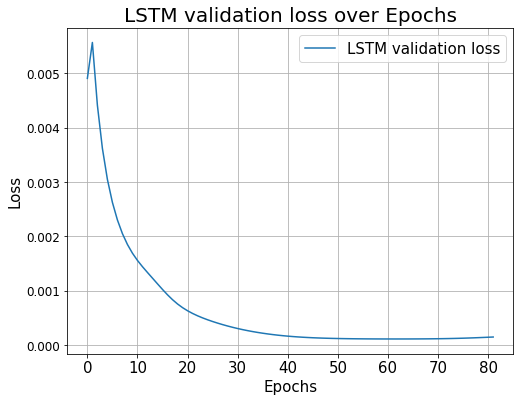

In [ ]:
# LSTM validation loss over epochs
fig, ax = plt.subplots(1, 1, figsize=(8,6))
plt.plot(history.history['val_loss'], label='LSTM validation loss')
plt.xlabel('Epochs', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.yticks(fontsize=12)
plt.title('LSTM validation loss over Epochs', fontsize=20)
plt.grid()
plt.legend(fontsize=15)
plt.savefig("LSTM validation loss.png", format='png', dpi=1600, bbox_inches='tight')
plt.show()

**MinMax Scaler equation**
$$x' = \frac{(x - min)}{(max - min)} \times (new\ max\ value - new\ min\  value) + new\ min\ value$$<br/>


$$x = \frac{(max - min)\times (new\ min\ value + x') + (new\ max\ value - new\ min\ value)\times min}{new\ max\ value - new\ min\ value}$$

Where:

$x$ is the inverse scaled value
$x'$ is the scaled value
$min$ is the minimum value of the original data
$max$ is the maximum value of the original data.<br/>
$new\ max\ value$ and $new\ min\ value$ is the new range that we want to scale the data to. For example: $(1,0)\ or\ (1,-1)$

In [ ]:
# make a prediction 
# select the number of obersvtions for prediction
yhat_lstm_test = model.predict(test_X, verbose=1)
yhat_lstm_train = model.predict(train_X, verbose=1)


# invert scaling 
scaled_test_y = pd.DataFrame(test_y)
scaled_train_y = pd.DataFrame(train_y)
scaled_yhat_lstm_test = pd.DataFrame(yhat_lstm_test) ## ravel () converting into 1D array
scaled_yhat_lstm_train = pd.DataFrame(yhat_lstm_train)
#obtain the min and max from the training set
unscaled_train = pd.DataFrame(series_supervised[:len(train)])
#new feature range
new_max_value = 1 
new_min_value= 0
feature_range = new_max_value - new_min_value

def transform_column(column):
    min_value = min(unscaled_train.iloc[:, -steps_ahead + column.name])
    max_value = max(unscaled_train.iloc[:, -steps_ahead + column.name])
    return ((max_value - min_value) * (new_min_value + column) + (feature_range  * min_value)) / feature_range 
    
# invert scaling for actual
y_lstm_test = scaled_test_y.apply(transform_column, axis=0).values
y_lstm_train = scaled_train_y.apply(transform_column, axis=0).values
# invert scaling for forecast
yhat_lstm_test = scaled_yhat_lstm_test.apply(transform_column, axis=0).values
yhat_lstm_train = scaled_yhat_lstm_train.apply(transform_column, axis=0).values

48/48 [==============================] - 0s 2ms/step


In [ ]:
# Performance evaluation
# y = inv_scale_y[np.where(inv_scale_y != 0 )]
# yhat = inv_scale_yhat[np.where(inv_scale_y != 0 )]

rmse_test = sqrt(mean_squared_error(y_lstm_test , yhat_lstm_test ))
print('Test RMSE: %.5f' % rmse_test)
MAE_test = mean_absolute_error(y_lstm_test , yhat_lstm_test)
print('Test MAE: %.5f' % MAE_test)
r2 = r2_score(y_lstm_test , yhat_lstm_test)
print('Test r2: %.5f' % r2)
wMAPE_test = wMAPE(y_lstm_test , yhat_lstm_test)
print('Test wMAPE: %.5f ' % wMAPE_test)

Test RMSE: 216.35640
Test MAE: 133.52303
Test r2: 0.91420
Test wMAPE: 5.84596 


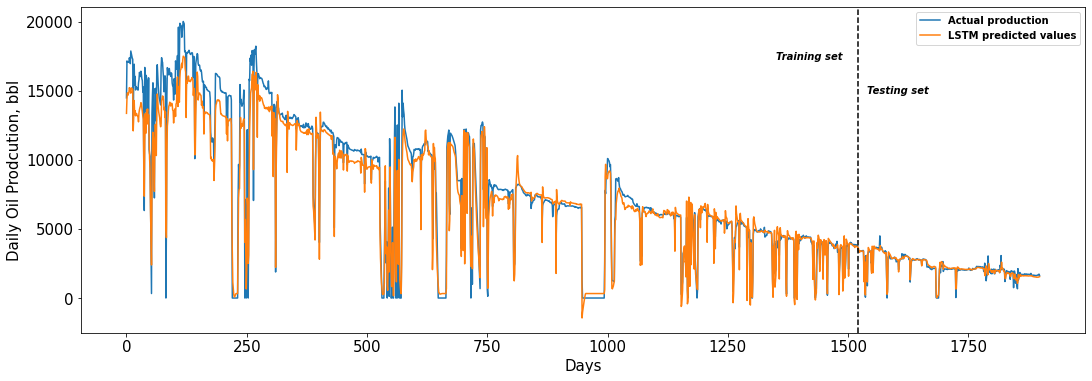

In [ ]:
# plot the concatenated  predcitions of both training and testing sets
entire_actual_lstm = np.concatenate([y_lstm_train, y_lstm_test], axis=0)
entire_forecast_lstm = np.concatenate([yhat_lstm_train, yhat_lstm_test], axis=0)

fig, ax = plt.subplots(1, 1, figsize=(18,6))
plt.plot(entire_actual_lstm, label = 'Actual production')
plt.plot(entire_forecast_lstm, label = 'LSTM predicted values')

# create the horizontal dashed line
plt.axvline(x=train_X.shape[0] + 1, color='black', linestyle='--')
plt.legend()
# add text labels
plt.text(1350, 17500, 'Training set', rotation=0, verticalalignment='center', style='italic', fontweight='bold')
plt.text(1540, 15000, 'Testing set', rotation=0, verticalalignment='center', style='italic', fontweight='bold')

plt.ylabel('Daily Oil Prodcution, bbl', fontsize=15)
plt.xlabel('Days', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Create a font object with bold weight
font = FontProperties()
font.set_weight('bold')
plt.legend(fontsize=10, loc= 'upper right', prop=font)


plt.savefig("LSTM actual-forecast.svg", dpi=1600, bbox_inches='tight')
plt.show()


In [76]:
days = list(range(1, 1908))

In [82]:
import numpy as np

In [85]:
np.std(days)

550.5034059840139